About a year ago, I moved from my lovely Beacon Hill apartment (300 yards from the subway) to a house full of my friends (a 20-25 minute walk from the nearest subway stop). I'm super happy in my new house (we have chickens!) and it was totally the right decision, but at the time my new commute felt daunting - and many of my friends told me I'd regret giving up the convenience of my amazing Beacon Hill location. So, I did what any aspiring data scientist would do and started gathering data to prove them wrong. (See a theme in my [data collection](/posts/2018/06/hinge-experiment) posts yet? XD)

Apart from proving my friends that "the commute isn't that bad, and plus the MBTA is awesome", I had a few other questions I wanted to answer:

- what's the fastest way to get to work? bike, car, or bus?
- how often is the bus delayed from what I expect, and by how much?
- which bus is more reliable: the 70 (which is a 10-minute walk from my house), or the 64 (which is 2 minutes away)?

# Data collection

I set up a google spreadsheet to track my commute. For every trip to or from work, I tried to track:

- the time I left my house or office
- the time I got on the bus, and which bus it was
- the time I got off the bus
- the time I got to work or my house
- the time my most reliable app, OpenMBTA, said the bus would be there

I also kept track of my departure and arrival times on days when I walked or got a ride from my roommate. 

Here's what the data looks like, after some cleaning up:

In [217]:
import pandas as pd
import numpy as np
import datetime

import scipy.stats as sp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('white')

In [218]:
fname = 'Commute - Sheet1.tsv'
df = pd.read_csv(fname, sep='\t')
df = df.rename(columns={'Unnamed: 10': 'comments'})
# Replace the automatically-generated duration with NaN
df = df.replace('0:00:00', np.nan).dropna(how='all')

# Remove the one entry where I went to central
df = df.query('going_to != "central"')

# Convert time columns to datetime
cols_datetime = ['leave', 'bus_time', 'leave_bus', 'arrive', 'open_mbta_said']
for col in cols_datetime:
    df[col] = pd.to_datetime(df[col])

df.head()

,date,going_to,method,leave,bus_time,bus_number,leave_bus,arrive,duration,open_mbta_said,comments
0,7/5/2017,work,bus,2018-09-03 10:40:00,2018-09-03 10:43:00,64.0,2018-09-03 10:52:00,2018-09-03 11:00:00,0:20:00,NaT,NaN
1,7/5/2017,home,bus,2018-09-03 22:00:00,2018-09-03 22:10:00,64.0,2018-09-03 22:18:00,2018-09-03 22:20:00,0:20:00,NaT,NaN
2,7/7/2017,home,bus,2018-09-03 19:55:00,2018-09-03 20:10:00,70.0,2018-09-03 20:22:00,2018-09-03 20:29:00,0:34:00,NaT,NaN
3,7/8/2017,work,bus,2018-09-03 07:54:00,2018-09-03 08:03:00,64.0,NaT,NaT,-7:54:00,2018-09-03 08:07:00,NaN
4,7/10/2017,work,car,2018-09-03 08:31:00,NaT,NaN,NaT,2018-09-03 08:47:00,0:16:00,NaT,NaN


A note that I'll mostly be focusing on my commute _to_ work for many of these analyses, since I gathered much less data for my commute home. It turns out that I actually pretty rarely go straight home from work, and I didn't really want to deal with tracking those complexities. Also, on the days when I do go straight home, I often forgot to log my commute.

# Commute duration

First, I can ask the most basic question: how long does it take me to get to and from work, and how does that vary with the method of transportation I take?

In [219]:
# Convert the "duration" column into minutes
df['clean_duration'] = df['duration'].str.split(':').str[1].astype(float)

# Remove any negative durations (these are days when I forgot to write my arrival)
df.loc[df['duration'].str.startswith('-'), 'clean_duration'] = np.nan

df[['duration', 'clean_duration']].head()

,duration,clean_duration
0,0:20:00,20.0
1,0:20:00,20.0
2,0:34:00,34.0
3,-7:54:00,NaN
4,0:16:00,16.0


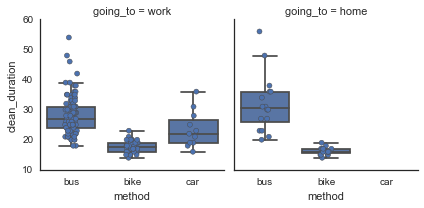

In [220]:
g = sns.FacetGrid(col='going_to', data=df)
g.map(sns.boxplot, 'method', 'clean_duration', 
      order=['bus', 'bike', 'car'],
      fliersize=0)
g.map(sns.stripplot, 'method', 'clean_duration',
      order=['bus', 'bike', 'car'],
      jitter=True, linewidth=0.5)

Let's also print some of these stats, using pandas' handy `describe` function on groupby objects.

In [221]:
(df.query('going_to != "central"')
    .groupby(['going_to', 'method'])
    .describe()
    ['clean_duration']
)

count       mean       std   min   25%   50%   75%   max
going_to method                                                          
home     bike     15.0  16.266667  1.279881  14.0  15.5  16.0  17.0  19.0
         bus      16.0  31.937500  9.629598  20.0  26.0  30.5  36.0  56.0
work     bike     40.0  17.650000  1.928863  14.0  16.0  17.5  19.0  23.0
         bus     101.0  28.455446  6.284146  18.0  24.0  27.0  31.0  54.0
         car      11.0  23.454545  6.088738  16.0  19.0  22.0  26.5  36.0

From regularly logging these data everyday, I already knew that (1) biking is the fastest and most reliable way to get to work and that (2) the bus took slightly longer than biking but wasn't that much different than driving. I knew in my heart that taking the bus was significantly longer than biking, but these boxplots are striking to me - looks like the median bus commute is 1.5-2 times longer than biking's! I don't need to do a statistical test to know these are different but hey, why not:

In [222]:
sp.ttest_ind(
    df.query('going_to == "work"').query('method == "bus"')['clean_duration'].dropna(),
    df.query('going_to == "work"').query('method == "bike"')['clean_duration'].dropna())

Ttest_indResult(statistic=10.657353135670544, pvalue=9.38443701751215e-20)

But, this is still good to know that, in general, getting to work takes around 30 minutes with the bus (door to door) and a little under 20 minutes by bike. 

I'm pretty surprised to see so many very long commutes to work: I can only recall a couple of bad days. I wonder if I made any notes for these... Let's grab these from the dataframe and view them directly.

In [223]:
long_commute = (
    df.query('going_to == "work"')
      .query('method == "bus"')
      .query('clean_duration > 40')
)
long_commute

,date,going_to,method,leave,bus_time,bus_number,leave_bus,arrive,duration,open_mbta_said,comments,clean_duration
14,7/25/2017,work,bus,2018-09-03 08:24:00,2018-09-03 08:36:00,64.0,2018-09-03 09:03:00,2018-09-03 09:06:00,0:42:00,2018-09-03 08:29:00,NaN,42.0
63,9/20/2017,work,bus,2018-09-03 08:33:00,2018-09-03 08:57:00,64.0,2018-09-03 09:24:00,2018-09-03 09:27:00,0:54:00,2018-09-03 08:39:00,rainy,54.0
66,9/26/2017,work,bus,2018-09-03 08:40:00,2018-09-03 08:57:00,64.0,2018-09-03 09:22:00,2018-09-03 09:26:00,0:46:00,2018-09-03 08:44:00,NaN,46.0
140,2/14/2018,work,bus,2018-09-03 08:24:00,2018-09-03 08:34:00,64.0,2018-09-03 09:09:00,2018-09-03 09:12:00,0:48:00,2018-09-03 08:27:00,NaN,48.0


Okay, so there are 4 days where it took me more than 40 minutes to get to work. I wonder if this was because the bus was late (i.e. I waited a long time at the bus stop) or because there was bad traffic (i.e. I spent a long time on the bus).

In [224]:
# Did I wait a very long time at the bus stop, or spend a long time in traffic?
print('Time at bus stop')
print(long_commute['bus_time'] - long_commute['leave'])

print('\nTime on the bus')
print(long_commute['leave_bus'] - long_commute['bus_time'])

Time at bus stop
14    00:12:00
63    00:24:00
66    00:17:00
140   00:10:00
dtype: timedelta64[ns]

Time on the bus
14    00:27:00
63    00:27:00
66    00:25:00
140   00:35:00
dtype: timedelta64[ns]


Okay, so I waited over 20 minutes for the bus on one of the trips, but otherwise the wait time was between 10 and 20 minutes. Seems that all four trips, however, took more than 20 minutes - this seems slightly high to me. But to know whether these are anomalies or not, I need to know how long I normally spend at the bus stop and on the bus:

In [225]:
# Add some new columns
df['time_at_bus_stop'] = df['bus_time'] - df['leave']
# Convert timedelta to something I can plot
df['time_at_bus_stop'] = df['time_at_bus_stop'].astype(str).str.split(':').str[1].astype(float)

df['time_on_bus'] = df['leave_bus'] - df['bus_time']
# Convert timedelta to something I can plot
df['time_on_bus'] = df['time_on_bus'].astype(str).str.split(':').str[1].astype(float)

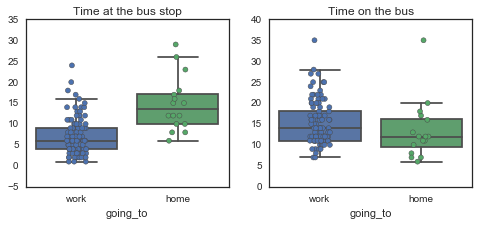

In [226]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

a = 0
sns.boxplot(data=df, x='going_to', y='time_at_bus_stop', ax=ax[a],
            fliersize=0)
sns.stripplot(data=df, x='going_to', y='time_at_bus_stop', ax=ax[a],
              jitter=True, linewidth=0.5)
ax[a].set_title('Time at the bus stop')
ax[a].set_ylabel('') 

a = 1
sns.boxplot(data=df, x='going_to', y='time_on_bus', ax=ax[a],
            fliersize=0)
sns.stripplot(data=df, x='going_to', y='time_on_bus', ax=ax[a],
              jitter=True, linewidth=0.5)
ax[a].set_title('Time on the bus')
ax[a].set_ylabel('')

Ah, so spending more than 10 minutes at the bus stop stop on my way to work is in the top quartile, as is spending more 20 minutes on the bus. Note, when I say "at the bus stop" I really mean "in transit to and at the bus stop". That's why it looks like I wait so much longer for the bus going home - part of it is that I am indeed worse at planning my evening commute, but a bigger part is that I have a 10 minute walk to the bus stop from work, no matter which bus I take home (vs. on the way to work, where the 64 is 2 minutes away from my house).

But anyway, it looks like the reason my very long commutes were very long was that _both_ the wait for the bus _and_ the time spent on the bus were longer than usual - there wasn't necessarily some catastrophic traffic where I was stuck for over an hour or something.

Something else that's surprising from these plots is that it looks like I spend about as much time on the bus at night than in the morning - I thought my evening bus rides were usually much shorter than my morning ones - especially when I leave late at night, I basically get on the bus and zoom home. Let's see!

Here, I'll plot the time of the bus vs. the time I spend on it. 

_Coding note: Trying a couple of intuitive plotting methods kept giving me errors, and it seems that making a **scatter** plot with some sort of DateTime object on the x-axis isn't super straightforward (e.g. seems to be an [open issue](https://github.com/pandas-dev/pandas/issues/18755) in pandas plotting). [This stackoverflow post](https://stackoverflow.com/questions/27472548/pandas-scatter-plotting-datetime) recommends a couple of workarounds, which I'll try one of!_

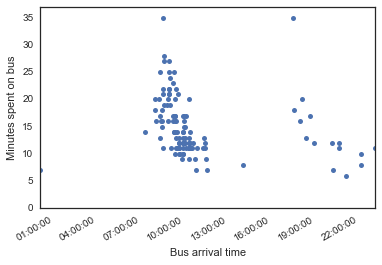

In [228]:
fig, ax = plt.subplots()
df.plot(kind='line', x='bus_time', y='time_on_bus', 
        style='.', ax=ax, markersize=10, legend=False)
_ = ax.set_ylim([0, 37])
ax.set_xlabel('Bus arrival time')
ax.set_ylabel('Minutes spent on bus')

*Coding note: `plt.scatter(tmp['bus_time'].astype(np.int64), tmp['time_on_bus'])` also works, but has less-nicely formatted x-ticks.*

Eh, maybe - it looks like leaving after 7 pm consistently leads to a short bus ride, but the floor is pretty much the same between morning and night. Interestingly, leaving later in the morning leads to a much shorter bus ride! It's actually not that interesting - anyone who lives in Boston/Cambridge/a city knows that traffic is way worse during rush hour, and I already knew this from experience. But at least now I have data to support my habit of working from home in the mornings! XD

# Bus delays

Ok, next question to assuage the haters: how reliable is the bus, and how often is it late? Here we'll also split up our analyses to try to answer the question about which bus is better, even though I already know the answer: it's the 64. This is also going to be obvious from the data because I really only take the 70 when I have to! I'm pretty sure it takes just as long, but is a bigger risk because I have to walk from farther to catch it. Let's see if my hunches are correct.

First, we'll calculate the delay using the `datetime` module.

In [229]:
def calculate_delay(row):
    delay = row['bus_time'] - row['open_mbta_said']

    if pd.notnull(delay):
        delay = datetime.timedelta.total_seconds(delay)
        delay = delay/60.0
    
    return delay

df['bus_delay'] = df.apply(lambda row: calculate_delay(row), axis=1)
df[['bus_time', 'open_mbta_said', 'bus_delay']].head(10)

,bus_time,open_mbta_said,bus_delay
0,2018-09-03 10:43:00,NaT,NaT
1,2018-09-03 22:10:00,NaT,NaT
2,2018-09-03 20:10:00,NaT,NaT
3,2018-09-03 08:03:00,2018-09-03 08:07:00,-4
4,NaT,NaT,NaT
5,NaT,NaT,NaT
6,2018-09-03 10:29:00,NaT,NaT
7,2018-09-03 18:07:00,NaT,NaT
9,2018-09-03 08:15:00,2018-09-03 08:16:00,-1
10,NaT,NaT,NaT


Hm, I guess I was pretty bad at keeping track of what my app said at the beginning of this experiment! Anyway, now we have a column with negative values when the bus was early and positive values when it was late. Drum roll please...

In [230]:
keep_buses = [64, 70]
delay = (df
         .dropna(subset=['bus_number', 'bus_delay'])
         .query('bus_number == @keep_buses')
         )
delay['bus_delay'] = delay['bus_delay'].astype(float)

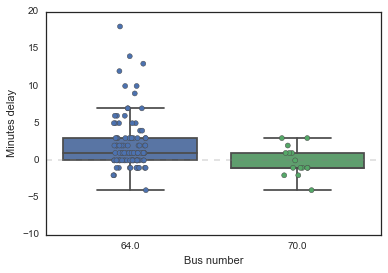

In [231]:
fig, ax = plt.subplots()
sns.boxplot(data=delay, x='bus_number', y='bus_delay',
            fliersize=0)
sns.stripplot(data=delay, x='bus_number', y='bus_delay',
              jitter=True, linewidth=0.5)
ax.axhline(0, linestyle='--', color='gray', alpha=0.25)
ax.set_xlabel('Bus number')
ax.set_ylabel('Minutes delay')

Oh nooo! It looks like (1) the 70 _might_ be more reliable than the 64 and that (2) the 64 is more often late than not!

Okay wait actually - it's okay if the 64 is more often late than early, given that I usually scramble out of my house 2 minutes before the app says it is due (this is, in fact, literal and not an exaggeration - I have gotten very good at jaywalking across Cambridge St). So a couple of minutes delay is great, since it means I can continue to not have my shit together and I won't miss my favorite bus! In fact, the more worrying thing is how often the 70 is _early_ - given that I have to walk there. The walk is definitely more than 5 minutes (I've tried), but in my mind feels like it _should_ be less than 10 (it probably isn't). 

Either way, all of these differences are matters of mere minutes - it doesn't matter that much in the grand scheme of things, and definitely won't motivate me to tweak my habits by mere minutes.

Alright, now that I've interpreted the data, let's do some stats! (This is sort of a tongue-in-cheek comment, but also not: if you can't interpret your data without the stats, then the patterns are probably not significant enough to be meangingful, even if they are statistically significant).

In [232]:
p = sp.ttest_1samp(
    df.query('bus_number == 64').dropna(subset=['bus_delay'])['bus_delay'], 
    popmean=0)
m = df.query('bus_number == 64').dropna(subset=['bus_delay'])['bus_delay'].mean()
print('The two-sided t-test for the hypothesis that the 64 \n'
      'bus has no delay has a pvalue of {:.2g} (mean delay = {} min).'.format(p[1], m))

The two-sided t-test for the hypothesis that the 64 
bus has no delay has a pvalue of 2.9e-08 (mean delay = 2.15 min).


In [233]:
p = sp.ttest_1samp(
    df.query('bus_number == 70').dropna(subset=['bus_delay'])['bus_delay'], 
    popmean=0)
m = df.query('bus_number == 70').dropna(subset=['bus_delay'])['bus_delay'].mean()
print('The two-sided t-test for the hypothesis that the 64 \n'
      'bus has no delay has a pvalue of {:.2g} (mean delay = {:.2f} min).'.format(p[1], m))

The two-sided t-test for the hypothesis that the 64 
bus has no delay has a pvalue of 0.8 (mean delay = -0.13 min).


So there it is: the buses are pretty darn good at being on time, if you're willing to allow for 5 minutes of wiggle room (which, considering Boston traffic, you absolutely should). Of course, as in all analyses, there are non-data factors to consider in interpreting these results. For example, most of the times when I take the 70, I'm going home and taking it from the first stop on its route. In these cases, it's almost always *exactly* on time - the driver is starting their new route, and the bus is often waiting for exactly the time to get going. There are many other factors that contribute to my favorable experience with these buses: I have a relatively short commute, I am very flexible on the time I actually get to work and therefore suffer few to no consequences when the bus is late, I live ridiculously close to my bus stop and so am super flexible on when I leave, my bus serves the Cambridge/Kendall area and so is likely more well-supported and/or less-overcrowded than other bus lines that serve farther or more working-class neighborhoods, etc etc.

# Bonus question: 9 am meetings?

Before I finish this post, maybe I can use this data to answer an important question that I have: what time do I need to leave my house in order to be on time to 9 am meetings? I really like to schedule breakfast meetings, but often find that the extra traffic combined with my lack of experience with leaving early means that I'm either leaving super early or scrambling to apologize for a 10-minute delay.

What time should I plan to take the bus if I want to be on campus by 9 am? And should I be rescheduling my meetings by 10-15 minutes to give myself substantially more time (20-30 minutes) to sleep in the mornings?

Unfortunately, I'm no longer at the airport with free Wi-Fi and am going to have to do some hacky things to get this question answered. (I should really invest a little bit of time to learn more about datetime data so I'm not so lost each time...) We'll use that other trick from above here.

In [234]:
# This is a super hacky way to get the equivalent time stamp for 9 am...
# But I'm on the airplane and want to finish this so it'll have to do!
# If I ever re-run this on a different day, I'll need to update this datetime
# to have the current date (pandas converts all date columns that only contain
# a time into a column with today's date and the provided time...)

# 7:30 am
print('7:30 am = {}'.format(
        pd.DataFrame(
            data=2*[pd.Timestamp(datetime.datetime(2018, 9, 3, 7, 30, 0))]
        ).astype(np.int64).iloc[0][0])
      )
# 9:00 am
print('9:00 am = {}'.format(
        pd.DataFrame(
            data=2*[pd.Timestamp(datetime.datetime(2018, 9, 3, 9, 0, 0))]
        ).astype(np.int64).iloc[0][0])
      )
# 9:15 am
print('9:15 am = {}'.format(
        pd.DataFrame(
            data=2*[pd.Timestamp(datetime.datetime(2018, 9, 3, 9, 15, 0))]
        ).astype(np.int64).iloc[0][0])
      )
# 9:30 am
print('9:30 am = {}'.format(
        pd.DataFrame(
            data=2*[pd.Timestamp(datetime.datetime(2018, 9, 3, 9, 30, 0))]
        ).astype(np.int64).iloc[0][0])
      )


7:30 am = 1535959800000000000
9:00 am = 1535965200000000000
9:15 am = 1535966100000000000
9:30 am = 1535967000000000000


In [235]:
seven30_am = 1535959800000000000
nine_am = 1535965200000000000
nine15_am = 1535966100000000000
nine30_am = 1535967000000000000

In [236]:
df['leave_int'] = df['leave'].astype(np.int64)
df['arrive_int'] = df['arrive'].astype(np.int64)

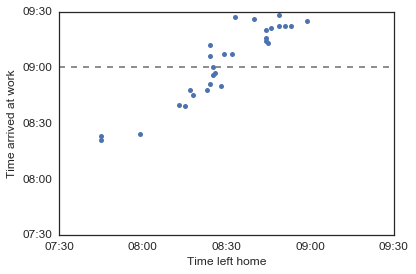

In [237]:
fig, ax = plt.subplots()
(df
    .query('bus_number == 64')
    .dropna(subset=['leave', 'arrive'])
    .plot(x='leave_int', y='arrive_int',
          kind='line', style='.', ax=ax,
          markersize=10, legend=False)
)
ax.set_xlim(seven30_am, nine30_am)
ax.set_ylim(seven30_am, nine30_am)

# Mark 9 am arrival
ax.axhline(nine_am, linestyle='--', color='gray')

def set_time_ticks(ax):
    # Manually set the ticks to half-hour increments
    times = [datetime.datetime(2018, 9, 3, 7, 30, 0),
             datetime.datetime(2018, 9, 3, 8, 0, 0),
             datetime.datetime(2018, 9, 3, 8, 30, 0),
             datetime.datetime(2018, 9, 3, 9, 0, 0),
             datetime.datetime(2018, 9, 3, 9, 30, 0)]
    # Again, get it into a pandas dataframe to then apply astype(np.int64)
    times = pd.DataFrame(data=times, columns=['datetime'])
    times['int_time'] = times['datetime'].astype(np.int64)
    ax.set_xticks(times['int_time'].values)
    ax.set_yticks(times['int_time'].values)

    ax.set_xticklabels([i.strftime('%H:%M') for i in times['datetime']], fontsize='large')
    ax.set_yticklabels([i.strftime('%H:%M') for i in times['datetime']], fontsize='large')

set_time_ticks(ax)
ax.set_xlabel('Time left home', fontsize='large')
ax.set_ylabel('Time arrived at work', fontsize='large')

Yes, that's what I thought - when I leave my house at 8:30, I sometimes make it before 9 am but sometimes not. Let's see if we can figure out which *bus* I should take to get to work before 9 am...

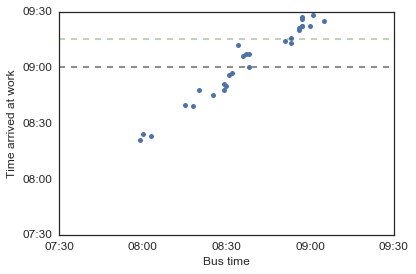

In [238]:
df['bus_time_int'] = df['bus_time'].astype(np.int64)

fig, ax = plt.subplots()
(df
    .query('bus_number == 64')
    .dropna(subset=['bus_time', 'arrive'])
    .plot(x='bus_time_int', y='arrive_int',
          kind='line', style='.', ax=ax,
          markersize=10, legend=False)
)
ax.set_xlim(seven30_am, nine30_am)
ax.set_ylim(seven30_am, nine30_am)

# Mark 9 am arrivale
ax.axhline(nine_am, linestyle='--', color='gray')
# And 9:15
ax.axhline(nine15_am, linestyle='--', color='darkgreen', alpha=0.3)

set_time_ticks(ax)

ax.set_xlabel('Bus time', fontsize='large')
ax.set_ylabel('Time arrived at work', fontsize='large')

Hm, it looks like there isn't a clear pattern here either - the 8:30 bus is just too uncertain! But I think I have an answer to my second question: if I schedule my breakfast meetings for 9:15 am, I will *definitely* make it on time if I take the 8:30 bus. Good to know!


# Conclusion

Much like my [previous post](/posts/2018/06/hinge-experiment) about online dating, I didn't learn too much from this analysis that I didn't already know. In this case, I already knew it because I paid attention when I logged my commute every day.

That said, looking at all the data together and seeing how much shorter biking is than taking the bus is pretty motivating - I should really get around to figuring out my basket/panier situtation, so that I can bike as often as frisbee injuries and the weather allows!

In conclusion, living in Allston is awesome because I am in a house full of my friends, a neighborhood full of actual real people (TM), and a backyard that lets us have three chickens. If that means that my commute to work is 30 minutes instead of 17, then so be it!
